In [15]:
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import inspect
import datetime
from scipy.stats import percentileofscore
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import add_preds
from functions import merge_data
from viz import  viz_interactive
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import matplotlib as plt
from scipy.stats import percentileofscore

# CHANGE THIS
from exponential_modeling import *
from fit_and_predict import *
#from pmdl_weights import * 

from shared_models import SharedModel

In [2]:
# Load in the Data
print('loading data...')
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))
#df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST,
#                          cached_dir=oj(parentdir, 'data'))

loading data...
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [3]:
# Currently selecting confirmed cases, can look at probable later
df_ucsf = pd.read_csv("../../covid-19-private-data/ucsf_hospitalization_data.csv", sep="\t")
df_ucsf = df_ucsf[["Date", "ZSFG COVID-19+ (total admitted)"]]
df_ucsf = df_ucsf.rename(columns={"ZSFG COVID-19+ (total admitted)": "hospitalizations"})
df_ucsf_hosp = df_ucsf["hospitalizations"] 
UCSF_data = np.array(df_ucsf_hosp.to_numpy())
UCSF_data

array([ 0,  0,  1,  1,  0,  0,  0,  0,  1,  3,  2,  1,  0,  1,  2,  2,  4,
        7,  7,  7,  9, 13, 15, 16, 18, 21, 23, 22, 25, 27, 30, 30, 30, 32,
       31, 33, 34, 28, 25, 25, 27, 25, 24, 26, 25, 26, 25, 23, 18, 19, 19,
       22, 24, 25])

## Eval Mode for Linear,Exponential, and Shared Exponential

In [4]:
#Linear,Exponential,Shared_Exponential Eval Mode for UCSF Data
eval_start_day = 20;
lin_predictions = []
exp_predictions = []
shared_exp_predictions = []
for i in range(eval_start_day,UCSF_data.shape[0]):   
    tmp = UCSF_data[:i+1]
    d = {'Name':['UCSF'],'hospitalizations':[tmp]}
    df_shared_UCSF = pd.DataFrame(data = d)
    shared_pred = fit_and_predict_shared_exponential(df_shared_UCSF,mode = "eval_mode",outcome = "hospitalizations")
    shared_exp_predictions.append(shared_pred[0][0])
    tmp = tmp.reshape(1,tmp.shape[0])
    lin_pred = linear_fit(tmp,'eval_mode')
    lin_predictions.append(lin_pred[0][0])
    exp_pred = exponential_fit(tmp,'eval_mode')
    exp_predictions.append(exp_pred[0][0])

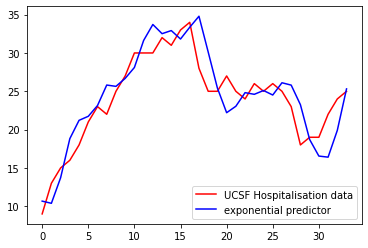

In [5]:
plt.plot(UCSF_data[eval_start_day:],'r',label='UCSF Hospitalisation data')
plt.plot(exp_predictions,'b',label='exponential predictor')
plt.legend()

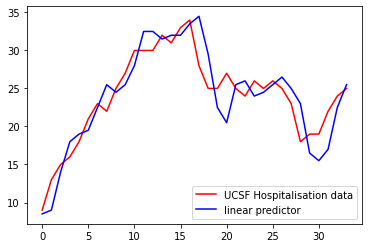

In [6]:
plt.plot(UCSF_data[eval_start_day:],'r',label='UCSF Hospitalisation data')
plt.plot(lin_predictions,'b',label='linear predictor')
plt.legend()

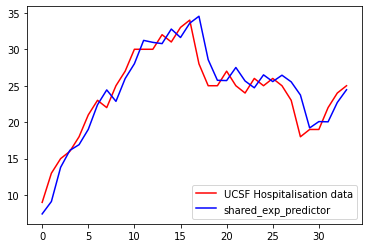

In [7]:
plt.plot(UCSF_data[eval_start_day:],'r',label='UCSF Hospitalisation data')
plt.plot(shared_exp_predictions,'b',label='shared_exp_predictor')
plt.legend()

## Defining Start Day and k

In [4]:
start_day = 20; # start_day >= 1; the index that we're predicting on
k = 1 #Number of days we want to predict ahead

## Future Predictions for Linear,Exponential, and Shared Exponential

In [187]:
lin_future_predictions = []
exp_future_predictions = []
shared_exp_future_predictions = []
for i in range(start_day,UCSF_data.shape[0]-k + 1):
    tmp = UCSF_data[:i] # Should there be an i+1 for predict_future? No
    d = {'Name':['UCSF'],'hospitalizations':[tmp]}
    df_shared_UCSF = pd.DataFrame(data = d)
    shared_future_pred = fit_and_predict_shared_exponential(df_shared_UCSF,mode = "predict_future",outcome = "hospitalizations",demographic_vars=[],target_day=np.array([k]), verbose=False)
    shared_exp_future_predictions.append(shared_future_pred[0][0])
    tmp = tmp.reshape(1,tmp.shape[0])
    lin_pred_future = linear_fit(tmp,'predict_future',target_day=np.array([k]))
    exp_pred_future = exponential_fit(tmp,'predict_future',target_day=np.array([k]))
    lin_future_predictions.append(lin_pred_future[0][0])
    exp_future_predictions.append(exp_pred_future[0][0])
    

In [138]:
# Mean Absolute Error (MAE) Calculations
lin_mae = np.mean(abs(lin_future_predictions - UCSF_data[start_day+k-1:]))
print("Linear MAE: "+str(lin_mae))
sepexp_mae = np.mean(abs(exp_future_predictions - UCSF_data[start_day+k-1:]))
print("Separate Exp MAE: "+str(sepexp_mae))
sharexp_mae = np.mean(abs(shared_exp_future_predictions - UCSF_data[start_day+k-1:]))
print("Shared Exp MAE: "+str(sharexp_mae))

Linear MAE: 2.1470588235294117
Separate Exp MAE: 2.1632784012493413
Shared Exp MAE: 1.744003229496975


In [139]:
# Log Scale Mean Absolute Error (LMAE) Calculations
lin_lmae = np.mean(abs(np.log(lin_future_predictions) - np.log(UCSF_data[start_day+k-1:])))
print("Linear log MAE: "+str(lin_lmae))
sepexp_lmae = np.mean(abs(np.log(exp_future_predictions) - np.log(UCSF_data[start_day+k-1:])))
print("Separate log Exp MAE: "+str(sepexp_lmae))
sharexp_lmae = np.mean(abs(np.log(shared_exp_future_predictions) - np.log(UCSF_data[start_day+k-1:])))
print("Shared Exp log MAE: "+str(sharexp_lmae))

Linear log MAE: 0.09873952287623246
Separate log Exp MAE: 0.09778441847656458
Shared Exp log MAE: 0.0803485811344157


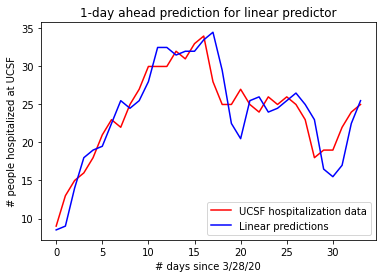

In [140]:
plt.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
plt.plot(lin_future_predictions,'b',label= "Linear predictions")
plt.legend()
plt.xlabel("# days since 3/28/20")
plt.ylabel("# people hospitalized at UCSF")
plt.title(str(k)+"-day ahead prediction for linear predictor")
plt.savefig("UCSF_Hospitalizations_plots/linear_"+str(k)+".jpg")

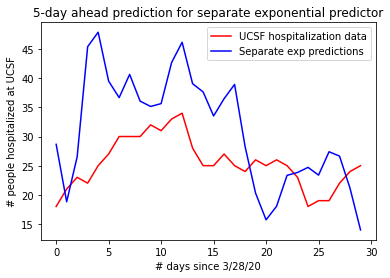

In [1171]:
plt.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
plt.plot(exp_future_predictions,'b',label= "Separate exp predictions")
plt.legend()
plt.xlabel("# days since 3/28/20")
plt.ylabel("# people hospitalized at UCSF")
plt.title(str(k)+"-day ahead prediction for separate exponential predictor")
plt.savefig("UCSF_Hospitalizations_plots/sepexp_"+str(k)+".jpg")

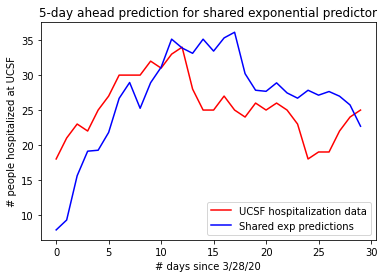

In [1172]:
plt.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
plt.plot(shared_exp_future_predictions,'b',label= "Shared exp predictions")
plt.legend()
plt.xlabel("# days since 3/28/20")
plt.ylabel("# people hospitalized at UCSF")
plt.title(str(k)+"-day ahead prediction for shared exponential predictor")
plt.savefig("UCSF_Hospitalizations_plots/sharexp_"+str(k)+".jpg")

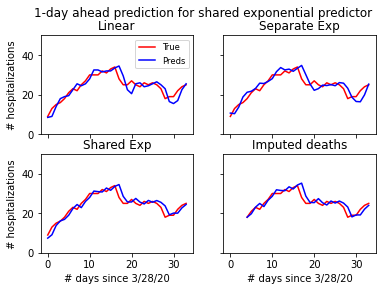

In [194]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs[0, 0].plot(UCSF_data[start_day+k-1:],'r',label = "True")
axs[0, 0].plot(lin_future_predictions,'b',label= "Preds")
axs[0, 0].set_title('Linear')
axs[0, 0].set_ylim([0, 50])
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
axs[0, 0].legend(prop=fontP)

axs[0, 1].plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
axs[0, 1].plot(exp_future_predictions,'b',label= "Separate exp predictions")
axs[0, 1].set_title('Separate Exp')

axs[1, 0].plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
axs[1, 0].plot(shared_exp_future_predictions,'b',label= "Shared exp predictions")
axs[1, 0].set_title('Shared Exp')

axs[1, 1].plot(np.arange(4, len(UCSF_data[start_day+k-1:])), UCSF_cen[start_day+k-1:],'r',label = "UCSF hospitalization data")
axs[1, 1].plot(np.arange(4, len(UCSF_data[start_day+k-1:])), np.array(preds),'b',label= "Imputed deaths shared exp predictions")
axs[1, 1].set_title('Imputed deaths')

for ax in axs.flat:
    ax.set(xlabel='# days since 3/28/20', ylabel='# hospitalizations')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(str(k)+"-day ahead prediction for shared exponential predictor")
plt.savefig("UCSF_Hospitalizations_plots/combinedplot_"+str(k)+".jpg", dpi=150)

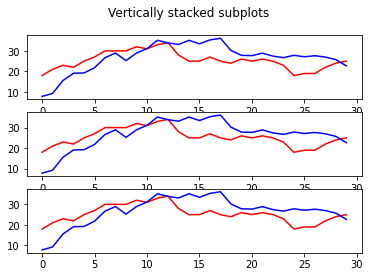

In [1174]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
ax1.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
ax1.plot(shared_exp_future_predictions,'b',label= "Shared exp predictions")
ax2.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
ax2.plot(shared_exp_future_predictions,'b',label= "Shared exp predictions")
ax3.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
ax3.plot(shared_exp_future_predictions,'b',label= "Shared exp predictions")

In [759]:
#df_CA = df_county[df_county['StateName']=='CA']
# df_CA.head()

#len(df_CA['deaths'].iloc[0])
# County data start date: 1/22/20
# print(df_county.columns.values)
# UCSF data start date: 3/8/20
# UCSF first date with 3+ hospitalizations: 3/17/20, 10 days after UCSF start
# print(df_ucsf)

In [673]:
# Start predicting from 3/8/20 onwards
# 46 days from the 1/22/20 to 3/8/20, not including the end date
# UCSF first prediction is: 3/12/20 

# death_preds = []
# for day in range(#edit date range):
#     df_CA_test = df_CA.copy(deep=True)
#     #append preds to death_preds
#     fit_and_predict_ensemble(df_CA_test)['predicted_deaths_ensemble_1']
#     for county in range(len(df_CA)):
#             # do we need to remove columns and truncate counts??
#             # truncate list counts: deaths, cases, neighbor_deaths, neighbor_cases
#             for col in ['deaths', 'cases', 'neighbor_deaths', 'neighbor_cases']:
#                 df_CA_test[col].iloc[county] = df_CA_test[col].iloc[county][:day]


In [ ]:
#  Why are we starting from 56?
# print(df_CA[df_CA['CountyName']=='San Francisco']['deaths'].values[0][56:])
# df_CA['deaths']

## Imputing Deaths 

$hospitalizations_{t} = \beta_0 hospitalizations_{t-1} + \beta_1 imputed\ deaths_{t} + \beta_2 imputed\ deaths_{t-1}$


In [5]:
shifted_date = 50 # 50 days between 1/22 and 3/12
cen = 4 # Number of days to censor on left + 1

In [190]:
# Calculate df_CA
df_CA = df_county[df_county['StateName'].isin(['CA', "WA"])]

# Compute the Imputed Deaths
# lin_impu_future_predictions = []
# exp_impu_future_predictions = []
# shared_impu_exp_future_predictions = []
## Censoring the UCSF_data

UCSF_cen = UCSF_data[cen:]
imputed_deaths = []

## Q: Should beginning of the range be 0 or the start_day?
## Q: Should we include this k? 
## A: I hate time series...
for i in range(1,UCSF_cen.shape[0]-k + 1): 
    df_CA_test = df_CA.copy(deep=True)
    # Calculate the Imputed Deaths
    for county in range(len(df_CA_test)):
            # do we need to remove columns and truncate counts??
            # truncate list counts: deaths, cases, neighbor_deaths, neighbor_cases
            for col in ['deaths', 'cases', 'neighbor_deaths', 'neighbor_cases']:
                # adding 1 to predict t
                df_CA_test[col].iloc[county] = df_CA_test[col].iloc[county][:shifted_date + i] 
    
    tmp = fit_and_predict_ensemble(df_CA_test, target_day=np.array([k]))
    sf_dop = tmp[tmp["CountyName"] == "San Francisco"]
    imputed_deaths.append(np.array(sf_dop["predicted_deaths_ensemble_" + str(k)])[0][0])

imputed_deaths = np.array(imputed_deaths)

In [191]:
# Should be a difference of k
print(len(imputed_deaths), UCSF_cen.shape)

49 (50,)


In [192]:
preds = []

for i in range(start_day,UCSF_cen.shape[0]-k + 1): 
    
    # Calculate the Imputed Deaths
    tmp = UCSF_cen[:i] # day t-1
    deaths = imputed_deaths[:i] # day t
    
    assert len(tmp) == len(deaths) 
    
    d = {'Name':['UCSF'],'hospitalizations':[tmp], "imputed_deaths": [deaths]}
    df_shared_UCSF = pd.DataFrame(data = d)
    
    # Feature Transforms
    feat_transforms = {}
    feat_transforms["hospitalizations"] = [lambda x: np.log(x+1)]
    feat_transforms["imputed_deaths"] = [lambda x: np.log(x + 1)]
    
    # Auxiliary Time Variables
    aux_vars = ["imputed_deaths"]
    shared_model = SharedModel(df_shared_UCSF,mode = "predict_future",
                                                            outcome = "hospitalizations",
                                                            demographic_variables=[],
                                                            auxiliary_time_features=aux_vars,
                                                            target_days=np.array([k]), 
                                                            feat_transforms=feat_transforms,
                                                            time_series_default_values = defaultdict(lambda: 0),
                                                            scale=False)
    
    
    shared_model.create_dataset()
    shared_model.fit_model()
    shared_model.predict()
    
    preds.append(shared_model.predictions[0][0])
    

In [193]:
imputed_mae = np.mean(abs(np.array(preds) - UCSF_cen[start_day+k-1:]))
print("Imputed MAE: "+str(imputed_mae))
imputed_lmae = np.mean(abs(np.log(np.array(preds)) - np.log(UCSF_cen[start_day+k-1:])))
print("Imputed Exp log MAE: "+str(sharexp_lmae))

Imputed MAE: 1.7007118322902068
Imputed Exp log MAE: 0.0803485811344157


Text(0.5, 1.0, '5-day ahead prediction for shared exponential model w/ Imputed Deaths ')

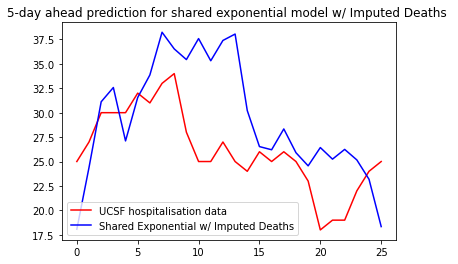

In [72]:
plt.plot(UCSF_cen[start_day+k-1:],'r',label = "UCSF hospitalisation data")
plt.plot(np.array(preds),'b',label= "Shared Exponential w/ Imputed Deaths")
# plt.plot(shared_exp_future_predictions[cen:],'orange',label= "future shared exponential predictions")
plt.legend()
plt.title(str(k)+"-day ahead prediction for shared exponential model w/ Imputed Deaths ")

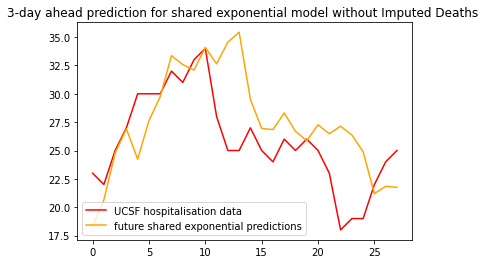

In [1021]:
plt.plot(UCSF_cen[start_day+k-1:],'r',label = "UCSF hospitalisation data")
plt.plot(shared_exp_future_predictions[cen:],'orange',label= "future shared exponential predictions")
plt.title(str(k)+"-day ahead prediction for shared exponential model without Imputed Deaths ")
plt.legend()

## Cumulative Sum


In [141]:
# This is a cumulative sum
UCSF_transf = np.cumsum(UCSF_data)
lin_cum_future_predictions = []
exp_cum_future_predictions = []
shared_cum_exp_future_predictions = []
for i in range(start_day,UCSF_transf.shape[0]-k + 1):
    tmp = UCSF_transf[:i] # Should there be an i+1 for predict_future? No
    d = {'Name':['UCSF'],'hospitalizations':[tmp]}
    df_shared_UCSF = pd.DataFrame(data = d)
    
    shared_cum_future_pred = fit_and_predict_shared_exponential(df_shared_UCSF,mode = "predict_future",outcome = "hospitalizations",demographic_vars=[],target_day=np.array([k]), verbose=False)
    shared_cum_exp_future_predictions.append(shared_future_pred[0][0])
    tmp = tmp.reshape(1,tmp.shape[0])
    
    lin_cum_pred_future = linear_fit(tmp,'predict_future',target_day=np.array([k]))
    exp_cum_pred_future = exponential_fit(tmp,'predict_future',target_day=np.array([k]))
    lin_cum_future_predictions.append(lin_cum_pred_future[0][0])
    exp_cum_future_predictions.append(exp_cum_pred_future[0][0])

Text(0.5, 1.0, '1-day ahead prediction for exp predictor for cumulative sum')

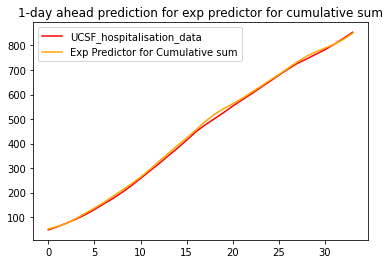

In [142]:
plt.plot(UCSF_transf[start_day+k-1:],'r',label = "UCSF_hospitalisation_data")
plt.plot(exp_cum_future_predictions,'orange',label= "Exp Predictor for Cumulative sum")
plt.legend()
plt.title(str(k)+"-day ahead prediction for exp predictor for cumulative sum")

In [101]:
x = np.array(exp_cum_future_predictions)
x[1:] -= x[:-1].copy()

Text(0.5, 1.0, '1-day ahead prediction for exp predictor based on cumulative sum')

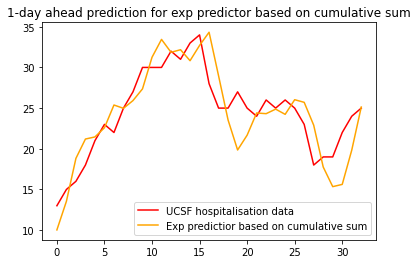

In [102]:
plt.plot(UCSF_data[start_day+k:],'r',label = "UCSF hospitalisation data")
plt.plot(x[1:],'orange',label= "Exp predictior based on cumulative sum")
plt.legend()
plt.title(str(k)+"-day ahead prediction for exp predictor based on cumulative sum")

In [103]:
cumexp_mae = np.mean(abs(x - UCSF_data[start_day+k-1:]))
print("Shared Exp log MAE: "+str(cumexp_mae))
cumexp_lmae = np.mean(abs(np.log(x) - np.log(UCSF_data[start_day+k-1:])))
print("Shared Exp log MAE: "+str(cumexp_lmae))

Shared Exp log MAE: 3.564933810044774
Shared Exp log MAE: 0.15548450903072808


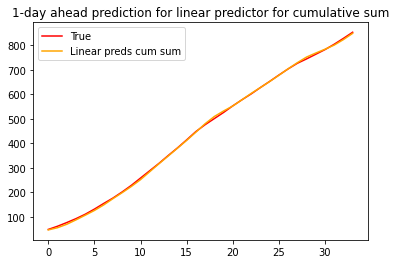

In [185]:
plt.plot(UCSF_transf[start_day+k-1:],'r',label = "True")
plt.plot(lin_cum_future_predictions,'orange',label= "Linear preds cum sum")
plt.legend()
plt.title(str(k)+"-day ahead prediction for linear predictor for cumulative sum")
plt.savefig("UCSF_Hospitalizations_plots/linear_fullcum_"+str(k)+".jpg", dpi=150)

In [144]:
x = np.array(lin_cum_future_predictions)
x[1:] -= x[:-1].copy()

In [171]:
lin_cum_future_predictions

[46,
 55.000000000000014,
 69.00000000000003,
 87.00000000000003,
 106.00000000000003,
 125.50000000000004,
 148.00000000000006,
 173.50000000000006,
 198.00000000000006,
 223.50000000000006,
 251.50000000000009,
 284.0,
 316.50000000000006,
 348,
 380.00000000000006,
 412.0,
 445.5000000000001,
 480.00000000000006,
 509.5000000000001,
 532.0000000000001,
 552.5000000000002,
 578.0000000000002,
 604.0,
 628.0000000000002,
 652.5000000000001,
 678.0000000000001,
 704.5000000000002,
 729.5000000000001,
 752.5000000000002,
 769.0000000000001,
 784.5000000000001,
 801.5000000000001,
 824.0,
 849.5]

In [172]:
lin_preds_undone = [lin_cum_future_predictions[0]]
for i in range(1, len(lin_cum_future_predictions)):
    lin_preds_undone.append(lin_cum_future_predictions[i]-lin_cum_future_predictions[i-1])
lin_preds_undone

[46,
 9.000000000000014,
 14.000000000000014,
 18.0,
 19.0,
 19.500000000000014,
 22.500000000000014,
 25.5,
 24.5,
 25.5,
 28.00000000000003,
 32.499999999999915,
 32.50000000000006,
 31.499999999999943,
 32.00000000000006,
 31.999999999999943,
 33.500000000000114,
 34.49999999999994,
 29.500000000000057,
 22.5,
 20.500000000000114,
 25.5,
 25.999999999999773,
 24.000000000000227,
 24.499999999999886,
 25.5,
 26.500000000000114,
 24.999999999999886,
 23.000000000000114,
 16.499999999999886,
 15.5,
 17.0,
 22.499999999999886,
 25.5]

In [161]:
len(UCSF_data[start_day+k:])
len(x[1:])
len(lin_future_predictions)
lenx

array([46. ,  9. , 14. , 18. , 19. , 19.5, 22.5, 25.5, 24.5, 25.5, 28. ,
       32.5, 32.5, 31.5, 32. , 32. , 33.5, 34.5, 29.5, 22.5, 20.5, 25.5,
       26. , 24. , 24.5, 25.5, 26.5, 25. , 23. , 16.5, 15.5, 17. , 22.5,
       25.5])

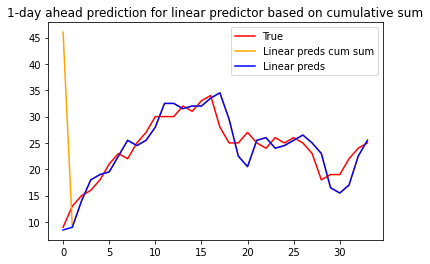

In [182]:
plt.plot(UCSF_data[start_day+k-1:],'r',label = "True")
plt.plot(lin_preds_undone,'orange',label= "Linear preds cum sum")
plt.plot(lin_future_predictions,'b',label= "Linear preds")

plt.legend()
plt.title(str(k)+"-day ahead prediction for linear predictor based on cumulative sum")
plt.savefig("UCSF_Hospitalizations_plots/linear_cum_"+str(k)+".jpg", dpi=150)

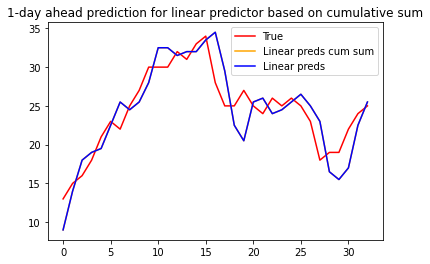

In [181]:
plt.plot(UCSF_data[start_day+k-1+1:],'r',label = "True")
plt.plot(lin_preds_undone[1:],'orange',label= "Linear preds cum sum")
plt.plot(lin_future_predictions[1:],'b',label= "Linear preds")

plt.legend()
plt.title(str(k)+"-day ahead prediction for linear predictor based on cumulative sum")
plt.savefig("UCSF_Hospitalizations_plots/linear_cumcut_"+str(k)+".jpg", dpi=150)

In [147]:
cumlin_mae = np.mean(abs(x - UCSF_data[start_day+k-1:]))
print("Shared Lin log MAE: "+str(cumlin_mae))
cumlin_lmae = np.mean(abs(np.log(x) - np.log(UCSF_data[start_day+k-1:])))
print("Shared Lin log MAE: "+str(cumlin_lmae))

Shared Lin log MAE: 3.2205882352941124
Shared Lin log MAE: 0.14504124067955362


In [183]:
cumlin_mae = np.mean(abs(lin_future_predictions[1:] - UCSF_data[start_day+k-1+1:]))
print("Shared Lin log MAE: "+str(cumlin_mae))
cumlin_lmae = np.mean(abs(np.log(lin_future_predictions[1:]) - np.log(UCSF_data[start_day+k-1+1:])))
print("Shared Lin log MAE: "+str(cumlin_lmae))

Shared Lin log MAE: 2.196969696969697
Shared Lin log MAE: 0.09999955648339257


In [176]:
cumlin_mae = np.mean(abs(x[1:] - UCSF_data[start_day+k-1+1:]))
print("Shared Lin log MAE: "+str(cumlin_mae))
cumlin_lmae = np.mean(abs(np.log(x[1:]) - np.log(UCSF_data[start_day+k-1+1:])))
print("Shared Lin log MAE: "+str(cumlin_lmae))

Shared Lin log MAE: 2.196969696969692
Shared Lin log MAE: 0.09999955648339236


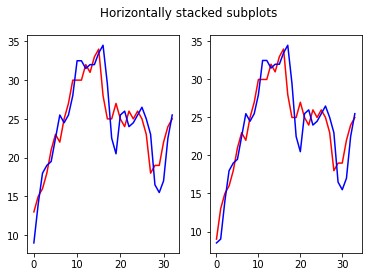

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(UCSF_data[start_day+k:],'r',label = "UCSF hospitalisation data")
ax1.plot(x[1:],'b',label= "Linear predictior based on cumulative sum")


# plt.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
# plt.plot(lin_future_predictions,'b',label= "Linear predictions")
# plt.legend()
# plt.xlabel("# days since 3/28/20")
# plt.ylabel("# people hospitalized at UCSF")
# plt.title(str(k)+"-day ahead prediction for linear predictor")
# plt.savefig("UCSF_Hospitalizations_plots/linear_"+str(k)+".jpg")

ax2.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
ax2.plot(lin_future_predictions,'b',label= "Linear predictions")

Text(0.5, 1.0, '3-day ahead prediction for linear predictor')

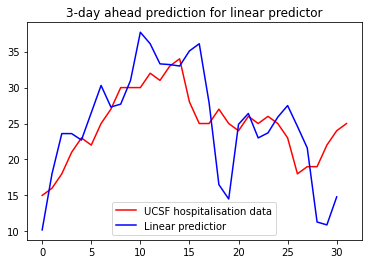

In [1029]:
plt.plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalisation data")
plt.plot(lin_future_predictions[1:],'b',label= "Linear predictior")
plt.legend()
plt.title(str(k)+"-day ahead prediction for linear predictor")

## Ensemble Modeling

In [16]:
ensemble = []
for i in range(start_day,UCSF_data.shape[0]-k+1): 
    tmp = UCSF_data[:i]
    d = {'Name':['UCSF'],'hospitalizations':[tmp]}
    df_shared_UCSF = pd.DataFrame(data = d)
    ensemble_prediction = fit_and_predict_ensemble(df_shared_UCSF,target_day = np.array([k]),outcome = 'hospitalizations', 
      methods = [exponential,linear],mode = 'predict_future', verbose = False)['predicted_hospitalizations_ensemble_1'].values[0][0]
    ensemble.append(ensemble_prediction)

print(ensemble)
#ensemble_prediction.head()

[9.398351275339724, 9.334904715829014, 13.934366162492998, 18.326690882103193, 20.139757584980103, 20.60116575150463, 22.773511241622106, 25.6158236224997, 24.909126375470994, 25.971099294035728, 28.044780385258985, 32.07456054374482, 33.124599136482956, 32.00844720567059, 32.47019399569895, 31.914344321876428, 33.43354911778034, 34.638535406303575, 29.80853005984903, 23.954451851382125, 21.339032605217483, 24.320756945458957, 25.318780446382505, 24.364687078669377, 24.796230533173937, 25.004383948798754, 26.299904656397697, 25.4217932292433, 23.133806200528113, 17.663161715562126, 16.01587476233029, 16.709337964713576, 21.00199797477643, 25.388667356865483]


In [13]:
ensemble_prediction

,Name,hospitalizations,y_preds_0,y_preds_1,predicted_hospitalizations_ensemble_1
0,UCSF,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 3, 2, 1, 0, 1, 2, ...",[10.66845873989866],[8.500000000000002],[9.398351275339724]


## MEPI

In [212]:
cut_data = UCSF_data
d = {'HospitalName':['UCSF'],'deaths':[cut_data], 'cases':[cut_data]}
tmp_df = pd.DataFrame(data = d)

In [214]:
ensemble_prediction

,HospitalName,deaths,cases,y_preds_0,y_preds_1,predicted_deaths_ensemble_1
0,UCSF,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 3, 2, 1, 0, 1, 2, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 3, 2, 1, 0, 1, 2, ...",[27.39522608464308],[27.500000000000004],[27.444285062145973]


In [217]:
ensemble = []
for i in range(start_day,UCSF_data.shape[0]-k+1): 
    tmp = UCSF_data[:i]
    d = {'Name':['UCSF'],'hospitalizations':[tmp]}
    df_shared_UCSF = pd.DataFrame(data = d)
    ensemble_prediction = fit_and_predict_ensemble(df_shared_UCSF,target_day = np.array([k]),outcome = 'hospitalizations', 
      methods = [exponential,linear],mode = 'predict_future', verbose = False)['predicted_hospitalizations_ensemble_3'].values[0][0]
    ensemble.append(ensemble_prediction)

print(ensemble)
#ensemble_prediction.head()


KeyError: 'deaths'